In [8]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import zscore

In [14]:
# Membaca file xlsx
file_path = "D:\\Haikal Coding\\DATA SCIENTIST\\LIDEA5\Assets\\1742915734389_production_data_history.xlsx"  # Sesuaikan path file
xls = pd.ExcelFile(file_path)
xls.sheet_names

<>:2: SyntaxWarning: invalid escape sequence '\A'
<>:2: SyntaxWarning: invalid escape sequence '\A'
C:\Users\MyBook Hype AMD\AppData\Local\Temp\ipykernel_27356\783826137.py:2: SyntaxWarning: invalid escape sequence '\A'
  file_path = "D:\\Haikal Coding\\DATA SCIENTIST\\LIDEA5\Assets\\1742915734389_production_data_history.xlsx"  # Sesuaikan path file


['in']

In [16]:
# Membaca data dari sheet "in"
df = pd.read_excel(xls, sheet_name="in", dtype=str)

In [18]:
# Memisahkan kolom menggunakan koma sebagai delimiter
df = df.iloc[:, 0].str.split(',', expand=True)

In [20]:

# Menetapkan nama kolom
df.columns = ["Date", "Well_ID", "Oil_Production", "Gas_Production", "Water_Production", "Choke_Size", "Pressure", "Temperature"]


In [22]:
# Mengganti string kosong atau "nan" dengan NaN
df.replace(["", "nan"], np.nan, inplace=True)


In [24]:

# Mengecek data
print("Mengecek Missing Values Sebelum Pembersihan:")
print(df.isnull().sum(), file_path)
print("Mengecek Data Duplikat Sebelum Pembersihan:") 
print(df.duplicated(subset=["Date", "Well_ID"]).sum(), file_path)


Mengecek Missing Values Sebelum Pembersihan:
Date                 0
Well_ID              0
Oil_Production      24
Gas_Production      23
Water_Production     0
Choke_Size           0
Pressure            32
Temperature         11
dtype: int64 D:\Haikal Coding\DATA SCIENTIST\LIDEA5\Assets\1742915734389_production_data_history.xlsx
Mengecek Data Duplikat Sebelum Pembersihan:
0 D:\Haikal Coding\DATA SCIENTIST\LIDEA5\Assets\1742915734389_production_data_history.xlsx


In [26]:
# Mengubah format data
# Konversi kolom Date ke format datetime
df["Date"] = pd.to_datetime(df["Date"], errors='coerce')

# Konversi kolom numerik ke format numeric
# numeric_columns adalah list dari nama kolom yang berisi data numerik
numeric_columns = ["Oil_Production", "Gas_Production", "Water_Production", "Choke_Size", "Pressure", "Temperature"]

# Konversi data di dalam kolom numerik ke format numeric
# errors='coerce' berarti jika ada nilai yang tidak dapat dikonversi maka diubah menjadi NaN
df[numeric_columns] = df[numeric_columns].apply(pd.to_numeric, errors='coerce')

In [28]:

# Menangani Missing Data dari Kolom Pressure dan Temperature
df["Pressure"] = df["Pressure"].interpolate(method='linear')
df["Temperature"] = df["Temperature"].interpolate(method='linear')

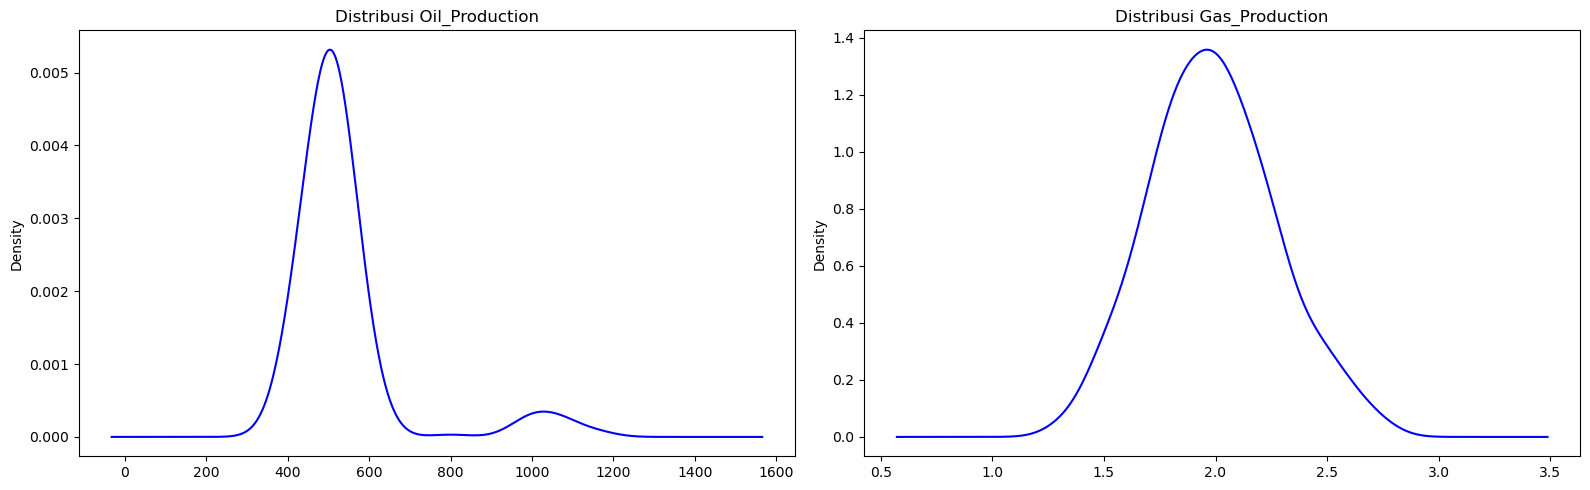

In [32]:
# Plot KDE for Oil_Production and Gas_Production
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(16, 5))

for axes, column in zip(ax, ["Oil_Production", "Gas_Production"]):
    df[column].plot(kind='kde', ax=axes, color='blue', title=f'Distribusi {column}')

plt.tight_layout()
plt.show()

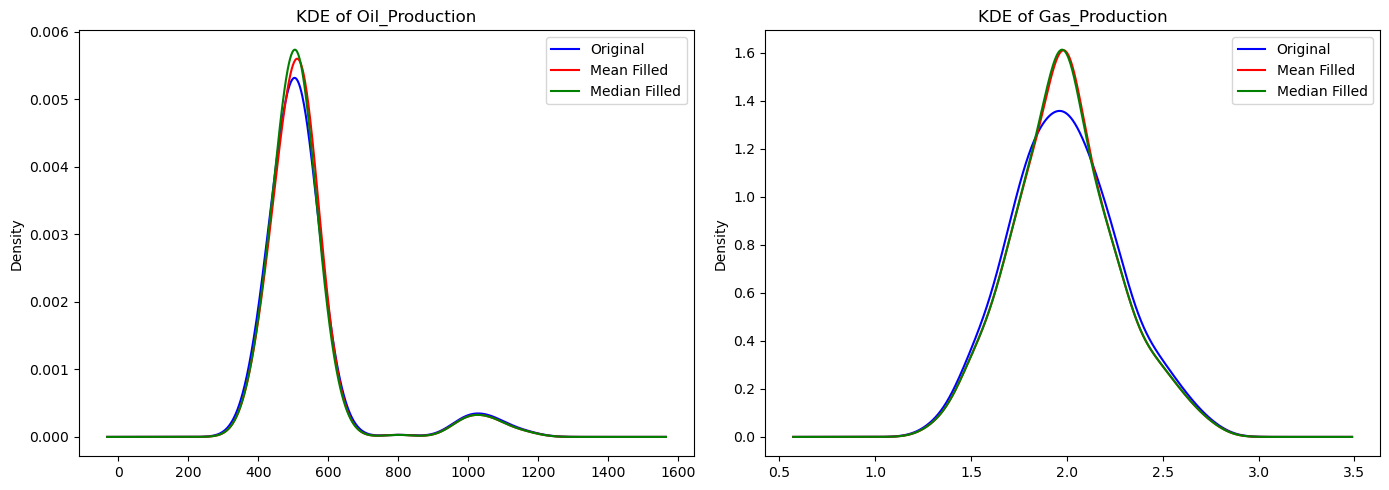

In [34]:
# Plot untuk kolom: Oil_Production dan Gas_Production
fig, ax = plt.subplots(1, 2, figsize=(14, 5))

for axes, column in zip(ax, ['Oil_Production', 'Gas_Production']):
    original = df[column]
    mean_filled = df[column].fillna(df[column].mean())
    median_filled = df[column].fillna(df[column].median())

    original.plot(kind='kde', ax=axes, color='blue', label='Original')
    mean_filled.plot(kind='kde', ax=axes, color='red', label='Mean Filled')
    median_filled.plot(kind='kde', ax=axes, color='green', label='Median Filled')

    axes.set_title(f"KDE of {column}")
    axes.legend()

plt.tight_layout()

In [44]:
# Menggunakan forward-fill dan backward-fill untuk nilai yang masih kosong
df["Oil_Production"] = df["Oil_Production"].fillna(method='ffill')
df["Gas_Production"] = df["Gas_Production"].fillna(method='bfill')

C:\Users\MyBook Hype AMD\AppData\Local\Temp\ipykernel_27356\4270934339.py:2: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df["Oil_Production"] = df["Oil_Production"].fillna(method='ffill')
C:\Users\MyBook Hype AMD\AppData\Local\Temp\ipykernel_27356\4270934339.py:3: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df["Gas_Production"] = df["Gas_Production"].fillna(method='bfill')


In [46]:
# Menghapus baris jika lebih dari 30% kolom kosong
# threshold di sini berarti batas minimum jumlah kolom yang harus diisi
# jika jumlah kolom yang kosong lebih dari 30% maka baris tersebut akan dihapus
threshold = 0.3 * len(df.columns)  # 30% dari total kolom
df = df.dropna(thresh=threshold)  # hapus baris jika jumlah kolom kosong lebih dari 30%

In [105]:
target_columns = ['Oil_Production', 'Gas_Production', 'Pressure']

# Hitung Z-score untuk setiap kolom
z_scores = df[target_columns].apply(zscore)  # Hitung Z-score untuk setiap kolom

# Mask untuk mendeteksi outlier (Z-score > 2.5 atau Z-score < -2.5)
outlier_mask = np.abs(z_scores) > 2.5

# Hitung jumlah outlier untuk setiap kolom
outlier_counts = {}
for column in target_columns:
    outlier_counts[column] = outlier_mask[column].sum()  # Hitung jumlah True (outlier)

# Tampilkan hasil
outlier_counts


{'Oil_Production': 21, 'Gas_Production': 3, 'Pressure': 20}

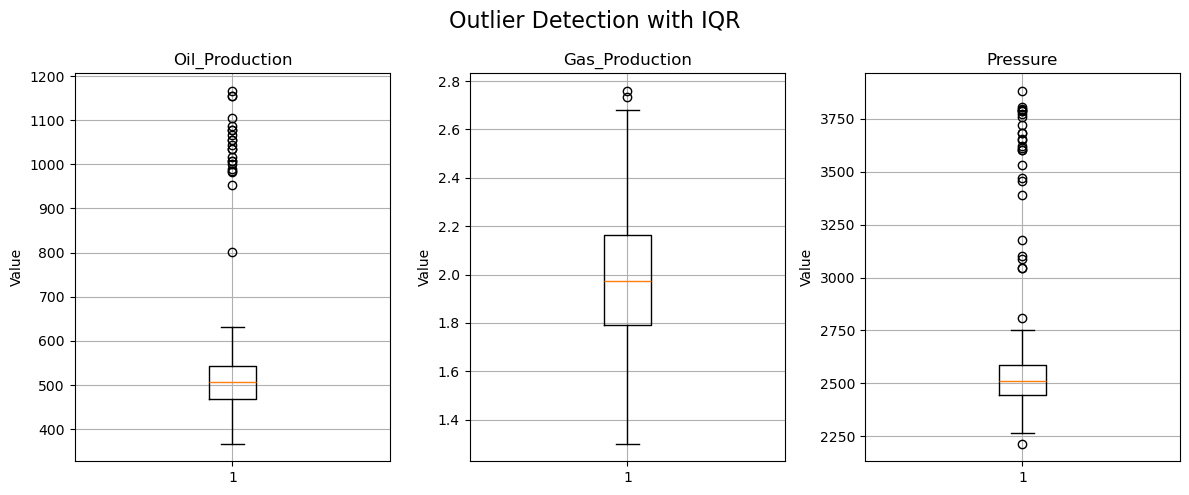

In [111]:
# --- Visualisasi Boxplot untuk Validasi Outlier ---

# Membuat subplots
fig, axes = plt.subplots(1, 3, figsize=(12, 5))  # Subplot untuk setiap kolom

# Loop setiap kolom dan buat boxplot-nya
for i, col in enumerate(target_columns):
    axes[i].boxplot(df[col].dropna())  # Drop NaN sebelum membuat boxplot
    axes[i].set_title(col)  # Set judul masing-masing subplot
    axes[i].set_ylabel('Value')  # Label sumbu y
    axes[i].grid(True)  # Tambahkan grid

# Set layout agar tidak overlapping
plt.suptitle('Outlier Detection with IQR', fontsize=16)  # Judul utama
plt.tight_layout()  # Atur layout agar pas dengan judul
plt.show()

In [64]:
# --- Tandai Special Event jika outlier karena kejadian nyata ---
df["Special_Event"] = outlier_mask.any(axis=1)

# --- Tangani Outlier (yang bukan special event) ---

# Misal: anggap zona = seluruh data sumur
for col in target_cols:
    # Baris yang outlier dan bukan event nyata
    mask = outlier_mask[col] & ~df["Special_Event"]
    
    if col == "Pressure":
        # Untuk Pressure, pakai interpolasi
        df.loc[mask, col] = df[col].interpolate(method='linear')
    else:
        # Untuk produksi minyak & gas, pakai rata-rata zona
        df.loc[mask, col] = df[col].mean()

In [113]:
# Menghapus duplikasi berdasarkan (Date, Well_ID)
df = df.drop_duplicates(subset=["Date", "Well_ID"])

In [115]:
# Standardisasi Format Data
df["Date"] = df["Date"].dt.strftime('%Y-%m-%d')
df["Pressure"] = df["Pressure"] * 14.5038  # Konversi bar ke psi

In [ ]:
# # Menyimpan data bersih
cleaned_file_path = "D:\\Haikal Coding\\DATA SCIENTIST\\LIDEA5\\Assets\\production_cleaned_data.xlsx"
df.to_excel(cleaned_file_path, index=False)